# Test Simple Maze

## Preliminary Exploration

In [6]:
from environments import SimpleMaze
import numpy as np

In [7]:
HIGHER_DIM_OBS = True
env = SimpleMaze(higher_dim_obs=HIGHER_DIM_OBS)

In [8]:
state = env.reset()[0]

In [9]:
np.set_printoptions(threshold=float('inf'))
print(state)

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1

In [18]:
env.action_space.n

4

In [19]:
state = env.reset()

In [20]:
next_state, reward, done, _ = env.step(2)
import torch

In [21]:
print(torch.allclose(torch.as_tensor(next_state[0]), torch.as_tensor(state[0])))
# state = next_state

False


# Plotting

In [1]:
import pytorch_lightning as pl
import torch
from crar_lightning import CRARLightning
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.patches import Circle, Rectangle
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, HPacker
matplotlib.use("qt5agg")
%matplotlib inline

In [4]:
# matplotlib.rcParams.keys()
from environments import SimpleMaze

In [47]:
pretrained_model = CRARLightning.load_from_checkpoint('simple_maze_lightning/version_0/checkpoints/epoch=38.ckpt')

In [48]:
def plot_maze(state):
    matplotlib.rcParams['figure.figsize'] = (10, 10)
    plt.figure()
    c = plt.pcolor(state[0], edgecolors='k', linewidths=1, cmap='RdBu', vmin=0.0, vmax=1.0)
    plt.colorbar(c)
    plt.show()

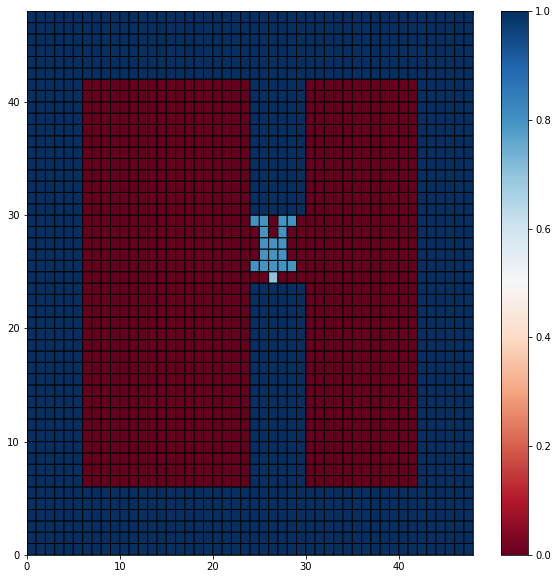

In [49]:
HIGHER_DIM_OBS = True
env = SimpleMaze(higher_dim_obs=HIGHER_DIM_OBS)
state = env.reset()
plot_maze(state)

In [50]:
all_inputs = env.all_possible_inputs()
all_inputs.shape

(31, 1, 48, 48)

In [51]:
encoded_inputs = pretrained_model.agent.encode(all_inputs)
exp1 = pretrained_model.replay_buffer.buffer[-1]

In [52]:
from typing import Union
def most_recent(buffer, n: Union[None, int] = None):
        if n is None:
            return buffer[0]
        buffer_copy, vals = buffer.copy(), []
        for _ in range(n):
            vals.append(buffer_copy.popleft())

        return vals

In [53]:
exp1000 = list(
    reversed(most_recent(pretrained_model.replay_buffer.buffer, 1000))
)

In [54]:
def plot_maze_abstract_transitions(exp_seq, all_inputs, 
                                   all_abs_inputs, model):
    matplotlib.rcParams['figure.figsize'] = (15, 15)
    n = 1000
    history = []
    for i, (obs, *_) in enumerate(exp_seq):
        history.append(obs)
    history = np.array(history)
    print(history.shape)
    
    abstract_states = model.agent.encode(history)
    m = cm.ScalarMappable(cmap=cm.jet)
    x, y = abstract_states.detach().cpu().numpy().T
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    
    for i in range(n - 1):
        predicted1 = model.agent.compute_transition(
            abstract_states[i : i + 1],
            torch.as_tensor([0], device='cuda')
        ).detach().cpu().numpy()
        
        predicted2 = model.agent.compute_transition(
            abstract_states[i : i + 1],
            torch.as_tensor([1], device='cuda')
        ).detach().cpu().numpy()
        
        predicted3 = model.agent.compute_transition(
            abstract_states[i : i + 1],
            torch.as_tensor([2], device='cuda')
        ).detach().cpu().numpy()
        
        predicted4 = model.agent.compute_transition(
            abstract_states[i : i + 1],
            torch.as_tensor([3], device='cuda')
        ).detach().cpu().numpy()
        
        ax.plot(
            np.concatenate([x[i : i + 1], predicted1[0, :1]]),
            np.concatenate([y[i : i + 1], predicted1[0, 1:2]]),
            color="0.9",
            alpha=0.75,
        )
        
        ax.plot(
            np.concatenate([x[i : i + 1], predicted2[0, :1]]),
            np.concatenate([y[i : i + 1], predicted2[0, 1:2]]),
            color="0.65",
            alpha=0.75,
        )
        
        ax.plot(
            np.concatenate([x[i : i + 1], predicted3[0, :1]]),
            np.concatenate([y[i : i + 1], predicted3[0, 1:2]]),
            color="0.4",
            alpha=0.75,
        )
        
        ax.plot(
            np.concatenate([x[i : i + 1], predicted4[0, :1]]),
            np.concatenate([y[i : i + 1], predicted4[0, 1:2]]),
            color="0.15",
            alpha=0.75,
        )
    # Plot the dots at each time step depending on the action taken
    length_block = [[0, 18], [18, 19], [19, 31]]
    for i in range(3):
        colors = ['blue', 'orange', 'green']
        line3 = ax.scatter(
                    all_abs_inputs[length_block[i][0] : length_block[i][1], 0],
                    all_abs_inputs[length_block[i][0] : length_block[i][1], 1],
                    c=colors[i],
                    marker="x",
                    edgecolors="k",
                    alpha=0.5,
                    s=100,
                )
    axes_lims = [ax.get_xlim(), ax.get_ylim()]
    
    box1b = TextArea(
            " Estimated transitions (action 0, 1, 2 and 3): ", textprops=dict(color="k")
        )
    box2b = DrawingArea(90, 20, 0, 0)
    el1b = Rectangle((5, 10), 15, 2, fc="0.9", alpha=0.75)
    el2b = Rectangle((25, 10), 15, 2, fc="0.65", alpha=0.75)
    el3b = Rectangle((45, 10), 15, 2, fc="0.4", alpha=0.75)
    el4b = Rectangle((65, 10), 15, 2, fc="0.15", alpha=0.75)
    box2b.add_artist(el1b)
    box2b.add_artist(el2b)
    box2b.add_artist(el3b)
    box2b.add_artist(el4b)

    boxb = HPacker(children=[box1b, box2b], align="center", pad=0, sep=5)

    anchored_box = AnchoredOffsetbox(
        loc=3,
        child=boxb,
        pad=0.0,
        frameon=True,
        bbox_to_anchor=(0.0, 0.98),
        bbox_transform=ax.transAxes,
        borderpad=0.0,
    )
    ax.add_artist(anchored_box)

(1000, 1, 48, 48)


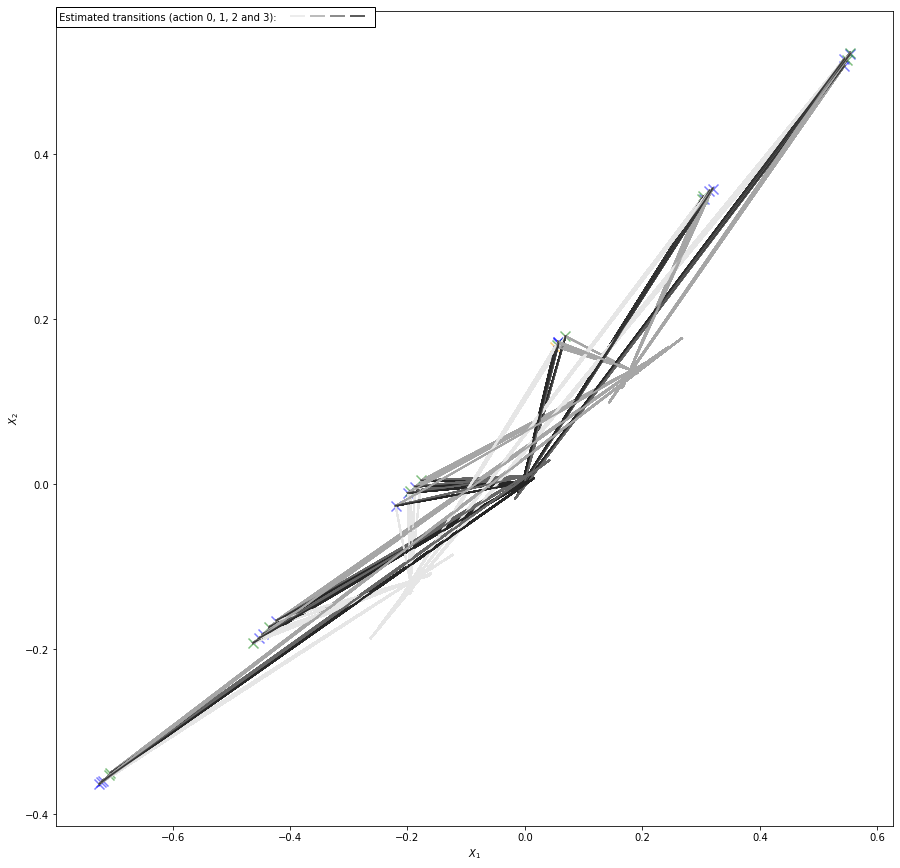

In [55]:
plot_maze_abstract_transitions(exp1000, all_inputs, 
                               encoded_inputs.detach().cpu().numpy(),
                               pretrained_model)